In [1]:
BASE_DIR = '/kaggle/input/utkface-new/UTKFace/'

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
# إعداد البيانات
image_paths, age_labels, gender_labels = [], [], []
for filename in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

In [5]:
df = pd.DataFrame({'image': image_paths, 'age': age_labels, 'gender': gender_labels})
gender_dict = {0: 'Male', 1: 'Female'}

In [6]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='rgb')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)
    features = np.array(features) / 255.0
    return features

In [7]:
X = extract_features(df['image'])
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [8]:
# بناء نموذج ResNet50
base_model = ResNet50(weights=None, include_top=False, input_shape=(128, 128, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
gender_output = Dense(1, activation='sigmoid', name='gender_out')(x)
age_output = Dense(1, activation='linear', name='age_out')(x)
model = Model(inputs=base_model.input, outputs=[gender_output, age_output])

In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 23,538,690 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [10]:
# تجميع النموذج
model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics={'gender_out': 'accuracy', 'age_out': 'mae'})

In [15]:
# تدريب النموذج
history = model.fit(X, [y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2, callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 73s 123ms/step - age_out_mae: 6.1056 - gender_out_accuracy: 0.8604 - loss: 6.4239 - val_age_out_mae: 8.7265 - val_gender_out_accuracy: 0.8402 - val_loss: 9.0849
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 70s 118ms/step - age_out_mae: 5.8239 - gender_out_accuracy: 0.8628 - loss: 6.1357 - val_age_out_mae: 6.6552 - val_gender_out_accuracy: 0.8397 - val_loss: 7.0105
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 70s 118ms/step - age_out_mae: 5.6181 - gender_out_accuracy: 0.8693 - loss: 5.9126 - val_age_out_mae: 7.4946 - val_gender_out_accuracy: 0.8631 - val_loss: 7.8009
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 70s 118ms/step - age_out_mae: 5.3530 - gender_out_accuracy: 0.8722 - loss: 5.6455 - val_age_out_mae: 6.7118 - val_gender_out_accuracy: 0.7999 - val_loss: 7.1934
Epoch 5/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 70s 118ms/step - age_out_mae: 5.0675 - gender_out_accuracy: 0.8779 - loss: 5.3476 - val_age_out_mae: 6.8285 - val_gender_out_accuracy: 0.8602 - val_loss: 7.

In [16]:
# Save the model (choose one of the options)
model.save('models/custom_ResNet50.h5')  # HDF5 format
# or
model.save('models/custom_ResNet50.keras')  # SavedModel format

# Save the history
np.savez('custom_ResNet50_history.npz', **history.history)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.858404 to fit



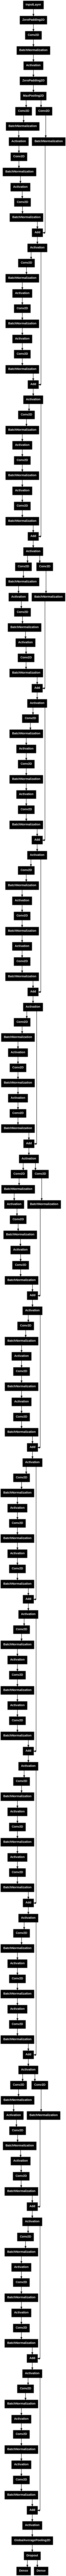

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model)

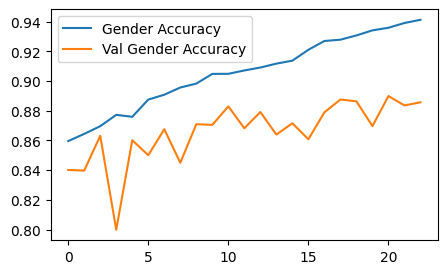

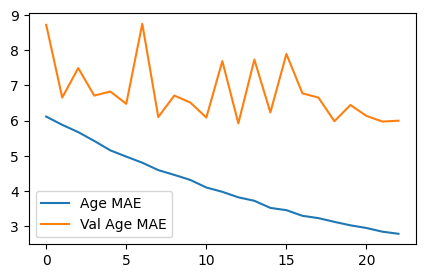

In [18]:
# عرض الرسوم البيانية للأداء
plt.figure(figsize=(5, 3))
plt.plot(history.history['gender_out_accuracy'], label='Gender Accuracy')
plt.plot(history.history['val_gender_out_accuracy'], label='Val Gender Accuracy')
plt.legend()
#plt.title('Gender Accuracy')
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(history.history['age_out_mae'], label='Age MAE')
plt.plot(history.history['val_age_out_mae'], label='Val Age MAE')
plt.legend()
#plt.title('Age MAE')
plt.show()

149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step


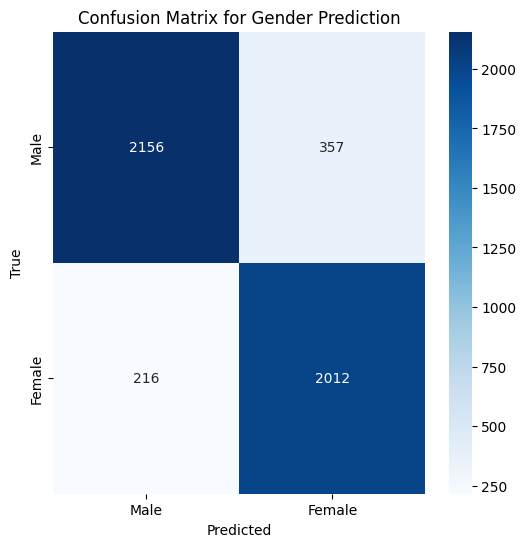

In [19]:
# حساب Confusion Matrix
val_split = int(len(X) * 0.2)
X_val = X[-val_split:]
y_gender_val = y_gender[-val_split:]

pred_gender = model.predict(X_val)[0]
pred_gender = (pred_gender > 0.5).astype(int)

cm = confusion_matrix(y_gender_val, pred_gender)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.title('Confusion Matrix for Gender Prediction')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Original Gender: Female Original Age: 18
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Gender: Female
Predicted Age: 19


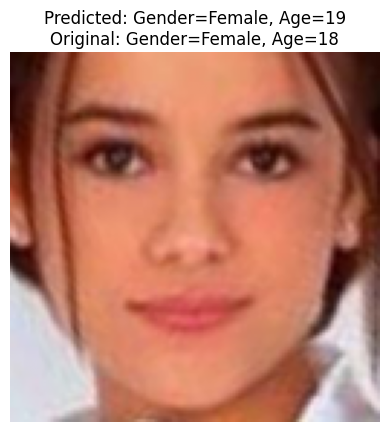

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# تعريف الصورة المطلوبة للتنبؤ
image_index = 10 # غيّر الرقم حسب الصورة التي تريد التنبؤ بها
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

# تجهيز الصورة
image = X[image_index]
image = image.reshape(1, 128, 128, 3)  # إضافة البعد الأول

# إجراء التنبؤ
predictions = model.predict(image)
predicted_gender = gender_dict[round(predictions[0][0][0])]
predicted_age = round(predictions[1][0][0])

# طباعة النتائج
print("Predicted Gender:", predicted_gender)
print("Predicted Age:", predicted_age)

# عرض الصورة مع النصوص
plt.imshow(X[image_index])
plt.title(f"Predicted: Gender={predicted_gender}, Age={predicted_age}\nOriginal: Gender={gender_dict[y_gender[image_index]]}, Age={y_age[image_index]}")
plt.axis('off')
plt.show()


Original Gender: Male Original Age: 45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Gender: Male
Predicted Age: 47


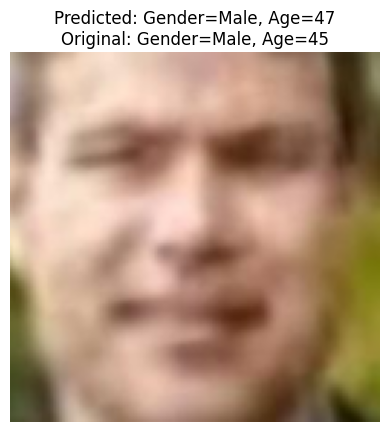

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# تعريف الصورة المطلوبة للتنبؤ
image_index = 2000  # غيّر الرقم حسب الصورة التي تريد التنبؤ بها
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

# تجهيز الصورة
image = X[image_index]
image = image.reshape(1, 128, 128, 3)  # إضافة البعد الأول

# إجراء التنبؤ
predictions = model.predict(image)
predicted_gender = gender_dict[round(predictions[0][0][0])]
predicted_age = round(predictions[1][0][0])

# طباعة النتائج
print("Predicted Gender:", predicted_gender)
print("Predicted Age:", predicted_age)

# عرض الصورة مع النصوص
plt.imshow(X[image_index])
plt.title(f"Predicted: Gender={predicted_gender}, Age={predicted_age}\nOriginal: Gender={gender_dict[y_gender[image_index]]}, Age={y_age[image_index]}")
plt.axis('off')
plt.show()


Original Gender: Male Original Age: 26
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Gender: Male
Predicted Age: 25


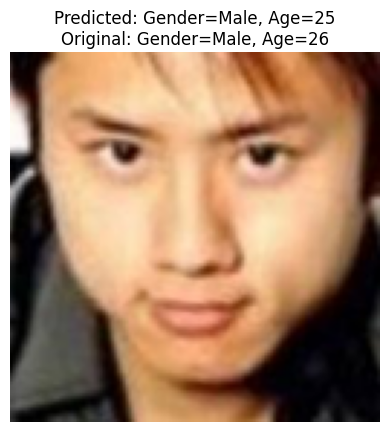

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# تعريف الصورة المطلوبة للتنبؤ
image_index = 0 # غيّر الرقم حسب الصورة التي تريد التنبؤ بها
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

# تجهيز الصورة
image = X[image_index]
image = image.reshape(1, 128, 128, 3)  # إضافة البعد الأول

# إجراء التنبؤ
predictions = model.predict(image)
predicted_gender = gender_dict[round(predictions[0][0][0])]
predicted_age = round(predictions[1][0][0])

# طباعة النتائج
print("Predicted Gender:", predicted_gender)
print("Predicted Age:", predicted_age)

# عرض الصورة مع النصوص
plt.imshow(X[image_index])
plt.title(f"Predicted: Gender={predicted_gender}, Age={predicted_age}\nOriginal: Gender={gender_dict[y_gender[image_index]]}, Age={y_age[image_index]}")
plt.axis('off')
plt.show()
